In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import os
from glob import glob
from tqdm import tqdm

from PIL import Image
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.applications import InceptionResNetV2
from keras import backend as K, layers
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
#More readable mapping
LESION_MAP = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous Cell Carcinoma'
}

In [3]:
isic_df = pd.read_csv('../../Skin Cancer Stuff/datasets/ISIC 2019/ISIC_2019_Training_GroundTruth.csv', index_col='image')
isic_df.head()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
image,,,,,,,,,
ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Searching for any empty data
isic_df.isna().sum()

MEL     0
NV      0
BCC     0
AK      0
BKL     0
DF      0
VASC    0
SCC     0
UNK     0
dtype: int64

In [5]:
#Creating a new dataframe with label targets for easy access
new_isic_dataset_columns = {
    'image_id': [],
    'target': []
}

for image_id, row in tqdm(isic_df.iterrows(), total = isic_df.shape[0]):
    #Ignoring possibilities of any repeats
    if image_id in new_isic_dataset_columns['image_id']:
        continue
        
    #ignoring squamous cell carcinoma
    scc = int(isic_df.loc[image_id]['SCC'])
    if scc:
        continue
    
    
    new_isic_dataset_columns['image_id'].append(image_id)
    mel = int(isic_df.loc[image_id]['MEL'])
    nev = int(isic_df.loc[image_id]['NV'])
    bcc = int(isic_df.loc[image_id]['BCC'])
    ak = int(isic_df.loc[image_id]['AK'])
    bkl = int(isic_df.loc[image_id]['BKL'])
    df = int(isic_df.loc[image_id]['DF'])
    vasc = int(isic_df.loc[image_id]['VASC'])
    
    #labels for each target
    if mel:
        new_isic_dataset_columns['target'].append('MEL')
    elif nev:
        new_isic_dataset_columns['target'].append('NEV')
    elif bcc:
        new_isic_dataset_columns['target'].append('BCC')
    elif ak:
        new_isic_dataset_columns['target'].append('AK')
    elif bkl:
        new_isic_dataset_columns['target'].append('BKL')
    elif df:
        new_isic_dataset_columns['target'].append('DF')
    elif vasc:
        new_isic_dataset_columns['target'].append('VASC')


100%|██████████| 25331/25331 [00:51<00:00, 495.80it/s]


In [6]:
new_isic_df = pd.DataFrame(new_isic_dataset_columns).set_index('image_id')

In [7]:
#Path to images
BASE_SKIN_DATASET = os.path.join("../../Skin Cancer Stuff/datasets/ISIC 2019")
ALL_IMAGE_PATH_MAP = {os.path.splitext(os.path.basename(x))[0]: x
                         for x in glob(os.path.join(BASE_SKIN_DATASET, '*', '*.jpg'))
                     }

#Fix the path
for k, v in ALL_IMAGE_PATH_MAP.items():
    a = ALL_IMAGE_PATH_MAP[k].replace("\\\\", "/")
    a = a.replace("\\", "/")
    ALL_IMAGE_PATH_MAP[k] = a

In [17]:
#Add path of each image to dataframe
new_isic_df['image_path'] = new_isic_df.index.map(ALL_IMAGE_PATH_MAP.get)

In [18]:
new_isic_df.head()

,target,image_path
image_id,,
ISIC_0000000,NEV,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...
ISIC_0000001,NEV,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...
ISIC_0000002,MEL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...
ISIC_0000003,NEV,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...
ISIC_0000004,MEL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...


In [19]:
new_isic_df['target'].value_counts()

NEV     12875
MEL      4522
BCC      3323
BKL      2624
AK        867
VASC      253
DF        239
Name: target, dtype: int64

<AxesSubplot:>

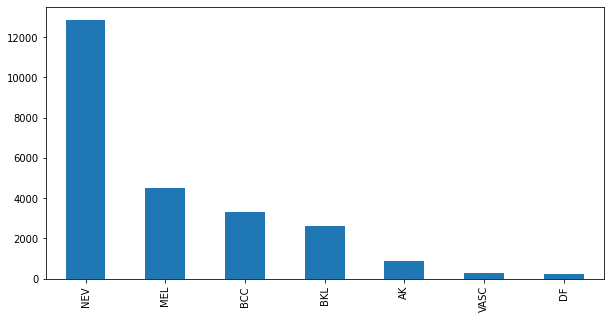

In [20]:
figure, axis_1 = plt.subplots(1, 1, figsize= (10, 5))
new_isic_df['target'].value_counts().plot(kind='bar', ax=axis_1)

In [ ]:
#Adding corresponding image rows for easy access
new_isic_df['image'] = new_isic_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [ ]:
new_isic_df['lesion_type_index'] = pd.Categorical(new_isic_df['target']).codes

In [ ]:
#Image path can be removed, since the images are now already loaded in
del new_isic_df['image_path']

In [ ]:
#x values and y values
input_features = new_isic_df.drop(columns=['lesion_type_index'],axis = 1)
labels = new_isic_df['lesion_type_index']

In [ ]:
#split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(input_features, labels, test_size=0.20, random_state=42)